# Final Assignment (Prompt 2) COGS 185
## Contributors:
- Andrew Lona

## Project Prompt (3)
Option 3: Collecting CA Legislature dataset and trying to produce meaningful results by using the char rnn model.

Larger than 1,500 word essay containing
- abstract
- introduction
- method
- experiment
- conclusion
- references

Bonus Points Possibilities (must be included as separate section):

- Novel ideas and applications
- Large efforts in own data collection/preparation
- state-of-the-art results on applications
- new algorithms or neural network architectures

## Goal for this project
The goal is to develop a Char RNN model pipeline which can be easily tweaked and scored for creating accurate generative text for Legislative text.

## Motivation for this project
Based on my sort of personal project for the past year, I aim to develop usable pipelines which can assist others in better understanding complex legal language contained without our governmental systems, such as the California Legislature. Creating a Char RNN model to conduct next-word prediction for bill language could possibly help us understand what words, phrases, sentences and bills would most likely lead to the most complex form of language. Such as if we generate predictions on complex language to see if that carries on.

Other motivations for this (related to the bonus portion) is that with an interactive, easy-to-use interface, researchers could easily train Char RNN models on any subset of data within the california legislature in order to better understand legal trends between certain dates, or figure any differences among assembly bills and senate bill types. The possibilities are definitely beyond the scope of my own imagination, but having a rough setup for less experienced researchers would be very helpful. As such, output of the model performance along with multiple tweaking parameters are a must for any interface.

## Literature Review, detailing the need/importance of legalese simplification, along with background research into the topic which should potentially speed up progress.
- *Poor writing, not specialized concepts, drives processing difficulty in legal language* (Martinez, et al., 2022)
    - Details how legalese comprehension difficulty is not just noticeable, but directly tied to poor writing practices. Provides framework for testing and goals for scaling readability.
- *Plain English Summarization of Contracts* (Manor and Li, 2019)
    - An earlier attempt at legalese simplification, albeit with a simpler model and more statistically rigid readability scoring criteria. Also says "this is a very challenging task" (p. 2)

### Python Code Integration Process. Both in code and as a brief writeup of process + results.
- The pipeline will follow this process in the code below...

1. The user is asked to general parameters for bills they would like scraped from the CA Legislature website
2. Bill text is organized into a dataframe rows and saved as a csv and/or text file.
4. User is able to then generate a Char RNN using said dataframe of bill texts (if not, the process ends here)
    - similar to the bill scraper params, Char RNN params can be adjusted using the UI. Default params are given.
        - Seq length = 128
        - Start and End are random
        - Training Iterations = 10000
5. Once Char RNN completes, results are automatically generated and the user is now allowed to generate predictions from said model from the UI
    - An Applescript function will let users be notified once the model is finished training.
## Brief analysis of results
- The Char RNN itself will be evauluated utilizing the first 5 bills from each year range for all SB/ABs using the webscraper process, leading to a full dataset of [].
- The UI itself will be shown to a few potential users for input on usage.
    - 2 PoliSci PhD Students
    - 2 Masters Students
    - 2 Undergraduate or Recent Undergrad Students
    - 2 High School Students
    - 2 General Population (more than 5+ years from any education)

## What would success be at the end of this pipeline?
- On a very simple-level, success would be both a simple interface with a working Char RNN that can be reliably trained using any subset of data from the CA Legislature
- Reliably trained Char RNN means a model that can deliver decent results with the full date range data sample at 70% or more.
    - The good news with the integrated pipeline is that we could retrain with new data over and over.
- Because the purpose of this project is to deliver a tool for potential researchers to better explore the difficult-to-navigate legal language contained within the CA legislature, users themselves must be satisfied with the interface and can navigate it without assistance.
___

In [1]:
# Dividing Code Block. This is left here as a buffer to help with exporting
# Andy -06_08_2023

In [2]:
# Import Statements
# for data processing
import string
import random
import pandas as pd
import re

# for pytorch/modeling
import torch
import torch.nn as nn
# setting device type
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# for plotting
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# for webscraping
from bs4 import BeautifulSoup # Importing BS
import requests # and requests to do web scraping of CA Legislature

# For GUI
import PySimpleGUI as sg #GUI library

# Set the custom theme using defined colors
custom_theme = {
    'BACKGROUND': '#2c2c2c',
    'TEXT': '#e6e6e6',
    'INPUT': '#3a3a3a',
    'TEXT_INPUT': '#e6e6e6',
    'SCROLL': '#3a3a3a',
    'BUTTON': ('#e6e6e6', '#646464'),
    'BORDER': 1,
    'SLIDER_DEPTH': 0,
    'PROGRESS_DEPTH': 0,
    'PROGRESS': ('#01826B', '#D0D0D0'),
    'ACCENT1': ('#000000', '#a0a0a0'),
    'ACCENT2': ('#000000', '#d0d0d0'),
    'ACCENT3': ('#000000', '#f0f0f0'),
}

sg.theme_add_new('CustomTheme', custom_theme)


# multithreading
import threading # needed as GUI will freeze up if everything is running on the main thread

# used for testing user interaction-based functions, unused in final code
import time, sys
# time.sleep(2.5)

### 1. User asked to input quote and what they would like it simplified to.
- I managed to make get a GUI working (my first time wow)!
- This will be called as a function at the bottom...

### 2. Using the quote to webscrape the bill
- Simple function used to create structured url to search for the exact bill
- If the exact bill is not found, return an error asking user to try correcting their input
- If the exact bill is found, scrape the entire bill and prep for use in Step 3

In [3]:
def ca_legis_scrape_init(house_type, first_year, last_year, debug=False):
    # Some explanation below
    # What I've learned of the url and search structure from CA Legislature
    # The base url is this chunk:
    base_search_url =  "https://leginfo.legislature.ca.gov/faces/billSearchClient.xhtml?"

    # The session chunk is:
    #year_start_year_end = str(20212022) #all sessions from 1999 to 2022 [sessions are two year pairs ended with 2021-2022]
    #session_chunk = "session_year="+ year_start_year_end
    # so for the start and end sessions, we want a list of all sessions desired...
    first_start, first_end = map(int, first_year.split("-"))
    last_start, last_end = map(int, last_year.split("-"))

    years = ["session_year=" + str(year) + str(year + 1) for year in range(first_start, last_end + 1, 2)]
    if len(years) == 0 :
        print("check work for years")
        exit() #return None
    # Note: session years searches do not work for all years when using phrase search which is why for now
    # phrase searching is disabled

    # The keyword/search term chunk is: &keyword=test
    # Clearly states to surround the phrase in quotes
    # We are avoiding this as it's equivalent to Title String Contains Searching Internally

    # The house search term chunk is: &house=Both
    if house_type == "Both":
        house_type = ("&house=" + "Both")
    elif house_type == "Senate":
        house_type = ("&house=" + "Senate")
    else:
        house_type = ("&house=" + "Assembly")

    # The author search term chunk is: &author=All
    author = ("&author=" + "All") # for now we have to use all authors

    # and The law code search term chunk is: &lawCode=All
    law = ("&lawcode=" + "All") # same thing for law
    law_chunk =  law

    # a big issue is being able to pull the lists and saving them. Trying to navigate
    # their html/css objects to figure this out but for the sake of time I am leaving
    # that to the very end if I even have a chance.

    # --------------------- SCRAPING + DF INITIALIZATION LOOP FOR DATA ---------------------

    # Creating url search string to try checking all years
    column_names = ['Bill', 'Title', 'Author', 'Status', 'Session', 'Type']
    scrape_data = [] # generating temporary df to store table items

    for year_pair in years: # for each pair of years
        full_search_url = base_search_url + year_pair + house_type + author + law_chunk # creating url
        response = requests.get(url = full_search_url) # waiting for response from Legislature website
        soup = BeautifulSoup(response.content, 'html.parser') # creating soup from response

        for tr in soup.find(id='bill_results').find_all('tr'): # for each item in the table
            row = [td.text for td in tr.find_all('td')] # store them in a row
            if len(row) != 0: # accounting for first entry in table object which is Null
                row.append(year_pair.replace('session_year=', '')) # adding session years
                row[0] = row[0].strip().rstrip('\n').replace('-', '') # cleaning Bill for easier url building
                row.append(re.search(r'([A-Z]+)', row[0]).group(1)) # adding bill type
                scrape_data.append(row)


    scrape_data = pd.DataFrame(scrape_data, columns=column_names) # generate df with these rows
    # scrape_data['Bill'] = scrape_data['Bill'].str.strip().str.rstrip('\n') # cleaning
    # scrape_data['Bill'] = scrape_data['Bill'].str.replace('-', '') # more cleaning

    # Drop the rows with "X" bill referrals (these are repeats)
    scrape_data = scrape_data[~scrape_data['Bill'].str.contains('X')] # Drop the rows that contain the character
    # Reset the index
    scrape_data.reset_index(inplace=True, drop=True)

    # sending to next step
    return scrape_data

In [4]:
def text_cleaner(link):
    response = requests.get(url = link) # waiting for response from Legislature website using new url
    soup = BeautifulSoup(response.content, 'html.parser') # creating soup from response of new url
    soup_bill = soup.body.find(id="content_main").find(id="centercolumn").find(id="bill_all") # locate bill location
    text_content = soup_bill.get_text() # get bill text
    text_content = re.sub(r'\s+', ' ', text_content) # regex processing for extra spaces
    text_content = re.sub(r'\\[a-z0-9]{2}', '', text_content) # regex processing for string formatting
    return text_content

In [5]:
# string to int
def convert_to_int(value):
    try:
        value = int(value)
        return value
    except (ValueError, TypeError):
        return None

# string to float
def convert_to_float(value):
    try:
        value = float(value)
        return value
    except (ValueError, TypeError):
        return None

In [6]:
def ca_legis_scrape_content(init_df, bill_num, text):
    if bill_num == '': bill_num = len(init_df) # if user inputted nothing

    try: # bill_num convert to int
        bill_num = int(bill_num)
    except (ValueError, TypeError):
        return None

    # start of true function
    if text != "": # if the user specifies a search term (handled the same as CA Legis Website)
        init_df = init_df[init_df['Title'].str.contains(text)]
        init_df.reset_index(inplace=True, drop=True)
    if len(init_df) == 0: return None # no possible search

    # --------------------- SCRAPING TEXT LOOP ---------------------
    # now we need to prep our mass bill scraping
    bill_content_url = "https://leginfo.legislature.ca.gov/faces/billNavClient.xhtml?bill_id="
    bill_content = []

    for bill, session_year, b_type, limit in zip(init_df['Bill'], init_df['Session'], init_df['Type'], range(0, bill_num)): # for each row
        current_url = bill_content_url + session_year + '0' + bill # creating url
        bill_content.append(text_cleaner(link=current_url)) # web scrape + text cleaning function
        if limit == bill_num: break # if user specifies a certain scrap limit, end loop

    if bill_num < len(init_df): init_df = init_df.loc[0:(bill_num-1)].copy() # slicing if needed
    init_df["Text"] = bill_content # writing to df

    return init_df # sending back

In [7]:
# concatenates Bill Text
def concatenate_column(df_to_rip):
    column_values = df_to_rip["Text"].astype(str)  # Convert column to string type
    concatenated_string = ''.join(column_values)
    return concatenated_string

# Get a random sequence of the bill dataset.
def get_random_seq(file_length, file, user_seq_length):
    seq_len     = user_seq_length  # The length of an input sequence.
    start_index = random.randint(0, file_length - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq, all_chars, num_chars):
    tensor = torch.zeros(len(seq), 1, num_chars)
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq, all_chars):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor:
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target(file, file_length, all_chars, num_chars, user_seq_length):
    seq    = get_random_seq(file = file, file_length = file_length, user_seq_length = user_seq_length)
    input  = seq_to_onehot(seq[:-1], all_chars = all_chars, num_chars = num_chars)      # Input is represented in one-hot.
    target = seq_to_index(seq[1:], all_chars = all_chars).long() # Target is represented in index.
    return input, target



In [8]:
# class Net(nn.Module):
#     def __init__(self):
#         # Initialization.
#         super(Net, self).__init__()
#         self.input_size  = None   # Input size: Number of unique chars.
#         self.hidden_size = None   # Hidden size: 100. (default)
#         self.output_size = None   # Output size: Number of unique chars.
#
#         ###### To be filled ######
#         self.rnn_cell = nn.RNNCell(self.input_size, self.hidden_size)
#         self.linear = nn.Linear(self.hidden_size, self.output_size)
#         ###### To be filled ######
#
#     def set_n_chars(self, n_chars): # to allow for this threading madness to continue
#         self.input_size = n_chars
#         self.output_size = n_chars
#
#     def set_hidden_size(self, hidden_size): # to allow for this threading madness to continue
#         self.hidden_size = hidden_size
#
#     def forward(self, input, hidden):
#         """ Forward function.
#               input:  One-hot input. It refers to the x_t in homework write-up.
#               hidden: Previous hidden state. It refers to the h_{t-1}.
#             Returns (output, hidden) where output refers to y_t and
#                      hidden refers to h_t.
#         """
#         # Forward function.
#         hidden = torch.tanh(self.rnn_cell(input, hidden))###### To be filled ######
#         output = self.linear(hidden)###### To be filled ######
#
#         return output, hidden
#
#     def init_hidden(self):
#         # Initial hidden state.
#         # 1 means batch size = 1.
#         return torch.zeros(1, self.hidden_size).to(device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_size = None
        self.hidden_size = None
        self.output_size = None
        self.rnn_cell = None
        self.linear = None

    def set_n_chars(self, n_chars):
        self.input_size = n_chars
        self.output_size = n_chars
        self.initialize_rnn_cell()

    def set_hidden_size(self, hidden_size):
        self.hidden_size = hidden_size
        self.initialize_rnn_cell()

    def initialize_rnn_cell(self):
        if self.input_size is not None and self.hidden_size is not None:
            self.rnn_cell = nn.RNNCell(self.input_size, self.hidden_size)
            self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden):
        hidden = torch.relu(self.rnn_cell(input, hidden))
        output = self.linear(hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

In [9]:
# Training step function.
def train_step(net, opt, input, target, loss_func):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward.
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.


In [10]:
# Evaluation step function.
def eval_step(net, all_chars, num_chars, init_seq='W', predicted_len=100, gui=False):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq, all_chars = all_chars, num_chars = num_chars).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)

    # Set current input as the last character of the initial string.
    input = init_input[-1]

    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)

        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]

        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char

        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char, all_chars = all_chars, num_chars = num_chars)[0].to(device)

    if gui:
        print(predicted_seq)
    else:
        return predicted_seq


In [11]:
# to save txt file
def save_string_to_file(string, filename):
    with open(filename, 'w') as file:
        file.write(string)

# optimizer and loss functions set by user
def get_optimizer(user_optimizer, user_lr, net):
    if user_optimizer == 'Adam':
        return torch.optim.Adam(net.parameters(), lr=user_lr)
    elif user_optimizer == 'SGD':
        return torch.optim.SGD(net.parameters(), lr=user_lr)
    elif user_optimizer == 'RMS Prop':
        return torch.optim.RMSprop(net.parameters(), lr=user_lr)
    elif user_optimizer == 'Adagrad':
        return torch.optim.Adagrad(net.parameters(), lr=user_lr)

# I know we can't use different loss functions rn, this is meant for future uses for
# me. Kind of like having a GUI to easily model text data.

def get_loss_function(user_loss_func):
    if user_loss_func == 'Cross Entropy':
        return nn.CrossEntropyLoss()
#     elif user_loss_func == 'NLL':
#         return nn.NLLLoss()
#     elif user_loss_func == 'BCE With Logits':
#         return nn.BCEWithLogitsLoss()
#     elif user_loss_func == 'CTC':
#         return nn.CTCLoss()

In [12]:
# Global variables!
total = 100     # Max size of progress bar
message = ''    # Blank message string, used to send throughout functions and threads. Not needed yet
progress = 0    # current progress up to a maximum of "total"

def long_operation_thread_scraping(house, start_year, end_year, max_bills, search):
    global message, progress

    # Webscraping into dataframe func
    bill_df = ca_legis_scrape_init(house_type = house, first_year = start_year, last_year = end_year) # bills_df comes as dict with all bills found
    if bill_df is None: raise Exception("Error in your parameter input, are your year ranges making sense?\nDouble check to make sure everything looks okay.")
    progress += 30 # progress bar increase

    bill_df = ca_legis_scrape_content(init_df = bill_df, bill_num = max_bills, text = search)
    if bill_df is None: raise Exception("Error in your maximum bills input, did you input 0?")
    progress += 30

    bill_text = concatenate_column(bill_df) # concatenating for modeling
    progress += 30

    bill_df.to_csv('temp_df.csv') # saving df
    save_string_to_file(bill_text, 'temp_text.txt') # saving txt
    progress += 10

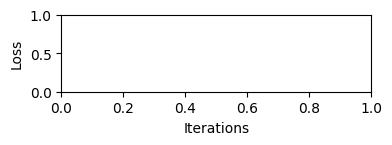

In [13]:
# generating global figure for plotting results
fig, ax = plt.subplots(figsize=(4,1))
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

# function to update loss value
def update_loss_plot(loss_values):
    ax.clear()
    ax.plot(loss_values)
    fig.canvas.draw()

# list to store loss values
all_losses_numpy = []

# for evaluation, we will need to create global variable to store final model
global_all_chars, global_num_chars = 0, 0

In [14]:
def long_operation_thread_modeling(user_seq_len, user_hidden_state, user_iters, user_iter_update, user_lr, user_predicted_len, user_loss_func, user_optimizer_func):
    global progress, message, net, all_losses_numpy, global_all_chars, global_num_chars

    try: # loading saved text file
        with open('temp_text.txt', 'r') as file:
            bill_text = file.read()
    except:
        raise Exception("Training Halted: Make sure you have text scraped first!")

    # converting all values
    user_seq_len = convert_to_int(user_seq_len)
    user_hidden_state = convert_to_int(user_hidden_state)
    user_iters = convert_to_int(user_iters)
    user_iter_update = convert_to_int(user_iter_update)
    user_lr = convert_to_float(user_lr)
    user_predicted_len = convert_to_int(user_predicted_len)
    numeric_inputs = [user_seq_len, user_hidden_state, user_iters, user_iter_update, user_lr, user_predicted_len]

    # Checks for zeroes or nulls which can result from improper inputs
    if all(var == 0 or var is None for var in numeric_inputs):
        raise Exception("Training Halted: Ensure your numbers are correct!")

    # making sure bill_text is minimum length
    if len(bill_text) <= user_seq_len: raise Exception("Training Halted: Character Size of your Dataset is too low for your Sequence Length.")

    # setting character info
    all_chars       = string.printable # all possible characters
    n_chars         = len(all_chars) # length of all possible characters
    file            = bill_text # pointing as a file (just to make it easier to expand this later)
    file = ''.join([char for char in file if char in all_chars]) # cleaning to prevent errors when one hotting
    file_len        = len(file) # length of file/aka char length

    print('Length of file: {}'.format(file_len))

    # omitted but the option is there
    # print('All possible characters: {}'.format(all_chars))
    # print('Number of all possible characters: {}'.format(n_chars))

    # initialize Network
    net = Net()
    net.set_n_chars(n_chars)
    net.set_hidden_size(user_hidden_state) # setting the hidden layers
    net.to(device) # setting the character length (from n_chars)

    # Number of iterations.
    # NOTE: You may reduce the number of training iterations if the training takes long.
    iters       = user_iters  # Number of training iterations.
    print_iters = user_iter_update    # Number of iterations for each log printing.

    # The loss variables.
    all_losses = [] # resets local list due to re-running of model
    all_losses_numpy = [] # resets global np for plotting
    loss_sum   = 0

    # User selected optimizer and loss function + lr initialization
    opt = get_optimizer(user_optimizer_func, user_lr, net)
    loss_func = get_loss_function(user_loss_func)

    # Training procedure.
    for i in range(iters):
        input, target = get_input_and_target(file = file, file_length = file_len, all_chars = all_chars, num_chars = n_chars, user_seq_length = user_seq_len) # Fetch input and target.
        input, target = input.to(device), target.to(device) # Move to GPU memory.
        loss      = train_step(net, opt, input, target, loss_func = loss_func)   # Calculate the loss.
        loss_sum += loss                                  # Accumulate the loss.

        # Print the log.
        if i % print_iters == print_iters - 1:
            print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
            print('generated sequence: {}\n'.format(eval_step(net, all_chars = all_chars, num_chars = n_chars, predicted_len = user_predicted_len)))
            progress = int((i / iters) * 100) # progress bar update

            # Track the loss.
            all_losses.append(loss_sum / print_iters)
            all_losses_numpy = [tensor.detach().cpu().numpy() for tensor in all_losses]
            loss_sum = 0

    # setting n and all to global for repeated evaluation/generation
    global_all_chars, global_num_chars = all_chars, n_chars

In [15]:
sg.theme_list()
def release_the_gui():
    # we're doing multithreading now! Basically just ensuring the GUI will work
    global message, progress, net, all_losses_numpy, global_all_chars, global_num_chars
    # there's no point in adding multiple threads for webscraping because it needs to be limited in timing
    # else we will be kicked from CA Legis
    # Also pytorch will be running on GPU so no need to multithread that, it's handled by pytorch

    # variables needed for certain UI elements
    year_ranges = [str(year) + '-' + str(year + 1) for year in range(1999, 2024, 2)] # bill year ranges
    model_run_count = 0

# --------------------- LAYOUT SECTION ---------------------
    sg.theme("CustomTheme") #I do like dark theme

    # Making/setting the layout of the window. Just an input field and some buttons to run all functions in proper order at the user's whim (without allowing multiple clicks)

    layout = [
        [
            sg.Text("Char RNN California Legislature Modeler\n", font=("Helvetica", 20), text_color="white", justification="center")
        ],
        [
            sg.Text("Note: Data must be loaded prior to training.", font=("Helvetica", 12), text_color="white", background_color=None, justification="center")
        ],
        [
            sg.Column(
                [
                    [sg.Text("Scraping Settings")],
                    [sg.Text("Input search text here: "), sg.InputText(key='-STRIN-', size=(30, 1))],
                    [sg.Text("House: "), sg.Combo(['Assembly', 'Senate', 'Both'], default_value='Assembly', key='-HOUSE-', readonly=True)],
                    [sg.Text("Start Year Range: "), sg.Combo(year_ranges, default_value='1999-2000', key='-START-YEAR-', readonly=True)],
                    [sg.Text("End Year Range: "), sg.Combo(year_ranges, default_value='2001-2002', key='-END-YEAR-', readonly=True)],
                    [sg.Text("Number of Bills to Scrape: "), sg.InputText(key='-MAX-BILLS-', size=(4, 1), default_text='1')],
                    [sg.Output(size=(50, 10))]
                ],
                justification="left",
                element_justification="left"
            ),
            sg.VSeperator(),
            sg.Column(
                [
                        [sg.Text("Training Settings")],
                        [sg.Text("Loss Function: "), sg.Combo(['Cross Entropy'], default_value='Cross Entropy', key='-LOSSFUNCT-', readonly=True)],
                        [sg.Text("Optimizer: "), sg.Combo(['Adam', 'SGD', 'RMS Prop', 'Adagrad'], default_value='Adam', key='-OPTIMIZER-', readonly=True)],
                        [sg.Text("Learning Rate: "), sg.InputText(key='-LEARNING-RATE-', size=(4, 1), default_text='0.05')],
                        [sg.Text("Hidden Layer Size: "), sg.InputText(key='-HIDDEN-LAYERS-', size=(4, 1), default_text='100')],
                        [sg.Text("Sequence Length: "), sg.InputText(key='-SEQ-LEN-', size=(4, 1), default_text='128'), sg.Text(" Characters")],
                        [sg.Text("Iterations: "), sg.InputText(key='-ITERATIONS-', size=(5, 1), default_text='20000')],
                        [sg.Text("Iteration Update: "), sg.InputText(key='-ITERATION-UPDATE-', size=(3, 1), default_text='100'), sg.Text(" Iterations")],
                        [sg.Text("Prediction Length: "), sg.InputText(key='-PREDICTED-LEN-', size=(3, 1), default_text='100'), sg.Text(" Characters")],
                        [sg.Canvas(key='-CANVAS-')], # to plot loss in real time
                        [sg.Text("Evaluate at: "), sg.InputText(key='-EVAL-CHARS-', size=(3, 1), default_text='100'), sg.Button("Go")]
                        # Add other elements to the right of the line
                ],
                justification="right",
                element_justification="right"
            )
        ],
        [sg.Button("Scrape"), sg.Button("Train"), sg.Button("Save", disabled="True"), sg.Button("Exit", button_color=("white", "red"))],
        [sg.Text('Work progress'), sg.ProgressBar(total, size=(20, 20), orientation='h', key='-PROG-')],
    ]

    window = sg.Window("CA Legal Char RNN", layout) # creating new window to read (display) in while loop
    figure_canvas_agg = None
    thread = None # nothing is running in the separate thread right now

    # --------------------- EVENT LOOP ---------------------

    while True: # while the sg event/window is in use
        event, values = window.read(timeout=100)
        if event in (None, "Exit"): # Exit this loop if the exit button is clicked
            break


        if event == 'Scrape' and not thread:
            house = values['-HOUSE-']
            start_year_range = values['-START-YEAR-']
            end_year_range = values['-END-YEAR-']
            print(f'Beginning scraping process for {house} House/s for the sessions of {start_year_range} to {end_year_range}...\n')
            thread = threading.Thread(target=long_operation_thread_scraping, args=(house, start_year_range, end_year_range, values['-MAX-BILLS-'], values['-STRIN-'],), daemon=True)
            thread.start()
            continue


        if event == 'Train' and not thread:
            # user inputs
            seq_len = values['-SEQ-LEN-']
            hidden_layers = values['-HIDDEN-LAYERS-']
            iterations = values['-ITERATIONS-']
            learning_rate = values['-LEARNING-RATE-']
            loss_funct = values['-LOSSFUNCT-']
            optimizer_func = values['-OPTIMIZER-']
            interation_update = values['-ITERATION-UPDATE-']
            predicted_length = values['-PREDICTED-LEN-']
            # print statement
            print(f'Beginning training process for {optimizer_func} optimizer with loss function {loss_funct} at {learning_rate} learning rate for {iterations} iterations with {hidden_layers} hidden layers and {seq_len} character sequence length...\n')
            # Allow for Model Saving
            window["Save"].update(disabled=False)
            window["Go"].update(disabled=False)
            # begin function
            thread = threading.Thread(target=long_operation_thread_modeling, args=(seq_len, hidden_layers, iterations, interation_update, learning_rate, predicted_length, loss_funct, optimizer_func,), daemon=True)
            thread.start()
            model_run_count += 1 # keeps track of our models
            continue

        if event == 'Save' and not thread:
            window["Save"].update(disabled=True)
            window["Scrape"].update(disabled=True)
            window["Train"].update(disabled=True)
            window["Go"].update(disabled=True)
            torch.save(net.state_dict(), f'model{model_run_count}.pth')
            print(f"Model State Dict Saved as {model_run_count}.\n")
            window["Save"].update(disabled=False)
            window["Scrape"].update(disabled=False)
            window["Train"].update(disabled=False)
            window["Go"].update(disabled=False)
            continue

        if event == 'Go' and not thread:
            eval_char_size = convert_to_int(values['-EVAL-CHARS-'])
            print(f"Evaluating at {eval_char_size} characters:  ")
            thread = threading.Thread(target=eval_step, args=(net, global_all_chars, global_num_chars, 'W', eval_char_size, True,), daemon=True)
            thread.start()
            continue

        if figure_canvas_agg is None: # initialize the Plot
            canvas = window['-CANVAS-'].TKCanvas
            figure_canvas_agg = FigureCanvasTkAgg(fig, master=canvas)
            figure_canvas_agg.draw()
            figure_canvas_agg.get_tk_widget().pack(side='top', fill='both')

        if thread:                                          # If thread is running
            window['-PROG-'].update_bar(progress, total)    # update the progress bar with the current progress amount

            # Draw the updated plot on the canvas
            update_loss_plot(all_losses_numpy)

            # disable buttons
            window["Scrape"].update(disabled=True)
            window["Train"].update(disabled=True)
            window["Save"].update(disabled=True)
            window["Go"].update(disabled=True)

            thread.join(timeout=0)


            if not thread.is_alive():                       # if the thread is finished/dead
                window["Save"].update(disabled=False)
                window["Scrape"].update(disabled=False)
                window["Train"].update(disabled=False)
                window["Go"].update(disabled=False)
                thread, message, progress = None, '', 0  # reset variables for next run
                window['-PROG-'].update_bar(0,0) # clear the progress bar
                print('\nFinished!\n\n') # Send complete message





    window.close() # Once the loop is done, close the window ending this function

In [16]:
if __name__ == '__main__':
    release_the_gui()
    exit()